***Steps***  
***Part 1: Log Collection/Cleaning***
1. Run `parser.py` file in '/Parsing'. Will parse files in 'rawlogs' into 'cleanlogs'. Creates log_structured.csv and log_templates.csv.
- Example code: `%run parser.py`
2. Use `clean_logs()` to clean log_structured.csv. Rename events to E1, E2 etc., creates log_structured_clean.csv.
- Example code: `clean_logs("./Parsing/cleanlogs/Zookeeper_2k.log_structured.csv","./Parsing/cleanlogs/Zookeeper_2k.log_templates.csv","Zookeeper")`.  
2. 1:  For labeled data use `label_log()` to label your log_structured_clean.csv log into log_labelled.csv. ***Currently for HDFS only***
- Example code: `label_log("./Parsing/cleanlogs/HDFS_structured_clean.csv","./Parsing/rawlogs/anomaly_label.csv")`.  
     
***Part 2: Log Parsing and Feature Extraction***  
3. Use `_session_window()` or `_fixed_window()` to parse and extract events from your log_structured_clean.csv or log_labelled.csv file. ***`_session_window()` for HDFS only***
- Example code (labeled): `x,y,df = _session_window(data_file="./Parsing/cleanlogs/HDFS_labelled.csv",labels=True)`.  
- Example code: `x,y,df = _fixed_window(data_file="./Parsing/cleanlogs/Zookeeper_structured_clean.csv",windowsize=2,log_type="Zookeeper")`.  
4. Use `_split_data()` to split x,y into training and testing sets.  ***split_type = 'uniform' is only for Labeled Data***.  
- Example code (labeled): = `(x_train,y_train),(x_test,y_test) = _split_data(x,y,train_ratio=0.5,split_type="uniform")`.  
- Example code (unlabeled): `(x_train, _),( x_test, _) = _split_data(x,y=None,train_ratio=0.5,split_type="sequential")`.  


In [12]:
#For Reading in Data
import pandas as pd
import numpy as np 

#For Creating labelled csv
from ast import literal_eval #For keeping ParameterList as List when reading in CSV 
import warnings
from pandas.core.common import SettingWithCopyWarning

#For Plot of Anomalies
import altair as alt

#For Log Parsing/Feature Extraction
import regex as re
from sklearn.utils import shuffle
from collections import OrderedDict
from datetime import timedelta   

In [13]:
###
### CSV Cleaning for Logs
###
def clean_logs(data_file,template_file,log_type):
    ###
    ###Clean log_structued.csv into new log_strucuted_clean.csv.
    ###
    ###Parameters: data_file, str (file path to log_strucutred.csv)
    ###Parameters: template_file, str (file path to log_template.csv)
    ###Parameters: log_type, str (for output file naming)
    ###
    ###Output: csv file
    
    #Read in the files from parser.py
    df_raw = pd.read_csv(data_file)
    template = pd.read_csv(template_file)
    
    
    #Create more clear EventIds: E1, E2
    template["Clean_EventId"] = ["E"+str(i+1) for i in range(0,len(template.EventId))]
    #Store new EventIds into Dictionary
    events = dict(zip(template.EventId,template.Clean_EventId))
    #Rename EventIds to E1,E2 ...
    df_raw.EventId = df_raw.EventId.map(events)

    #Create new CSV file log_structured_clean.csv
    df_raw.to_csv("./Parsing/cleanlogs/"+log_type+"_structured_clean.csv",sep=",",index=False)    

In [14]:
clean_logs("./Parsing/cleanlogs/HDFS_2k.log_structured.csv","./Parsing/cleanlogs/HDFS_2k.log_templates.csv","HDFS")

In [15]:
def label_log(data_file,label_file,log_type="HDFS"):
    ###
    ###Currently tailored to HDFS (looking at blkid as unique identifiers)
    ###Creates a log_labnelled.csv file
    ###
    ###Parameters: data_file, str (file path to log_structued_clean.csv)
    ###Parameters: label_file, str (file path to label file)
    ###Parameters: log_type, str (for output file naming)
    ###
    ###Output: csv file
    
    #Reading in Data
    anomaly = pd.read_csv(label_file)
    anomaly_labels = anomaly.set_index("BlockId")["Label"].to_dict()
    log_clean = pd.read_csv(data_file,converters={'ParameterList': literal_eval})
    warnings.simplefilter(action="ignore", category=SettingWithCopyWarning) #Ignore some warning messages 
    
    #Some functions for extracting block id
    def extract_blk_id(x):
    ###
    ###Check if entry is a blk_id, return True if value is a blk_id 
    ###
    ###Input: x, str
    ###Output: boolean
        if "blk" in x:
            return True
        
    #Individual Entries inside blk_id
    def extract_label(x): 
        ###
        ###Determine if given list of bulk_ids are normal, anomaly or not specified, return str. 
        ###In the case of multiple bulk_ids, if 1 blk_id corresponds to an Anomaly - will be classified as Anomaly. 
        ###If the blk_id is not in our dictionary of labels - will be classified as Unavailable.
        ###
        ###Input: x, list of blk_ids
        ###Output: label, str - either Normal, Anomaly or Unavailable
        for blk_id in x: #Go through list of blk_ids
            if blk_id in anomaly_labels.keys(): #Check if the id is in out list of labels
                
                if anomaly_labels[blk_id] == "Anomaly": #Find any Anomalies
                    return "Anomaly" 
                else:
                    return "Normal"
                
            else: #id does not exist in our dictionary (i.e. do not know label)
                return "Unavailable"

    #Create blk_id column
    count = 0
    log_clean["blk_id"] = "" #Initialize new column
    for params in log_clean.ParameterList:
        if params == []: #If the list is empty - when the IPLOM parser failed (on 3 occaisions) @ line 1438,1767,1900
            #Need to go to Content to get blk_id
            intermediate = [blkid for blkid in log_clean["Content"][count].split() if extract_blk_id(blkid)] 
            if len(intermediate) == 1:
                log_clean["blk_id"][count] = intermediate
            else: #BLOCK* ask 10.251.126.5 50010 to delete: Only want the blk_id from * not what is deleted
                 log_clean["blk_id"][count] = [intermediate[0]]
        else: 
            log_clean["blk_id"][count] = [blkid for blkid in params if extract_blk_id(blkid)] #Extract parameter entries with blk_id
        count+=1

    #Deal with weird cases such as: 
    #['blk_-7601381921195183756', 'mnt/hadoop/dfs/data/current/subdir48/blk_-7601381921195183756'] = Keep 1 blk_id
    #or 
    #[]'/user/root/randtxt2/_temporary/_task_200811101024_0002_m_000299_0/part-00299. blk_4984150784048864430']  or ['replicate blk_-7571492020523929240 to datanode(s) 10.251.122.38']= Extract blk_id
    count = 0
    for row in log_clean.blk_id: 
        if any("/" in sub for sub in row) or any(" blk" in sub for sub in row): #Rows with weird cases similar to above
            if len(row) == 2:
                temp = row[0]
                log_clean["blk_id"][count] = [temp]
            else:
                temp = row[0].split(" ")
                idx = [i for i, s in enumerate(temp) if 'blk' in s][0]
                log_clean["blk_id"][count] = [temp[idx]]
        count += 1
        
    #Create label column
    log_clean["label"] = [extract_label(blkid) for blkid in log_clean.blk_id] #Initialize new column

    #Export to CSV
    log_clean.to_csv("./Parsing/cleanlogs/"+log_type+"_labelled.csv",sep=",",index=False)

In [16]:
label_log(data_file = "./Parsing/cleanlogs/HDFS_structured_clean.csv",label_file = "./Parsing/rawlogs/anomaly_label.csv", log_type = "HDFS")

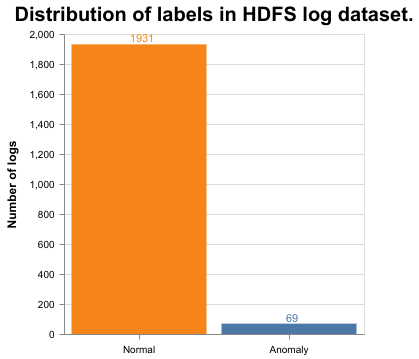

In [17]:
#Chart of Anomaly Distribution
HDFS_clean = pd.read_csv("./Parsing/cleanlogs/HDFS_labelled.csv")
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')
bars = alt.Chart(HDFS_clean).mark_bar().encode(
    alt.X("label",sort="-y", axis=alt.Axis(title= None,labelAngle=0)),
    alt.Y("count()",axis=alt.Axis(title="Number of logs")),
    alt.Fill("label",legend=None)
)

text = bars.mark_text(
    baseline='bottom',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='count()'
)

(bars+text).properties(width=300,height=300,title = "Distribution of labels in HDFS log dataset. ").configure_title(fontSize=20, align="left").configure_axis(labelPadding=5, titleFontSize=12, titlePadding = 10)

In [18]:
import regex as re
from sklearn.utils import shuffle
from collections import OrderedDict

#2.1 Load by Session Window
def _session_window(data_file,labels=False):
    ###
    ###Only available to HDFS data
    ###Seperate data by Session Window (i.e. unique identifier "blk_id")
    ###
    ###Parameters: data_file, str (file path to cleaned datafile)
    ###Parameters: labels, boolean (if you have label of logs or not)
    ###
    ###Output: x_data = array of list, each row of array is a blk_id with list being the eventsequence
    ###Output: y_data = array of list, each row of array is blk_id with 0 if Normal or 1 if Anomaly
    ###Output: event_df = pd.df of x_data with blk_id and y_label
    
    #Read in Structured Log (with Labels)
    if labels: 
        struct_log = pd.read_csv(data_file,converters={'blk_id': literal_eval})
        int_struct_log=struct_log[["EventId","blk_id","label"]] #Subset struct_log with only columns of interest EventId, blk_id and label
        data = int_struct_log.explode("blk_id") #Each blk_id is on it's own row
    else:
        struct_log = pd.read_csv(data_file,converters={'blk_id': literal_eval})
        int_struct_log=struct_log[["EventId","blk_id"]] #Subset struct_log with only columns of interest EventId, blk_id and label
        data = int_struct_log.explode("blk_id") #Each blk_id is on it's own row
    
    #Group Events by blk_id
    event_dict = OrderedDict() #Create empty dictionary
    for idx,row in data.iterrows(): #For each row in int_struct_log 
        if not row["blk_id"] in event_dict: #Check if blk_id exists already
            event_dict[row["blk_id"]] = [] 
        event_dict[row["blk_id"]].append(row['EventId']) #Add corresponding EventId to blk_id
    event_df = pd.DataFrame(list(event_dict.items()), columns=['BlockId', 'EventSequence']) #Convert data_dict into data_frame
    x_data = event_df['EventSequence'].values
    
    #Determine if blk_id is an Anomaly (1) or Normal (0)
    if labels:
        label_data = data.set_index('blk_id')
        label_dict = label_data['label'].to_dict()
        event_df['Label'] = event_df['BlockId'].apply(lambda x: 1 if label_dict[x] == 'Anomaly' else 0)
        y_data = event_df["Label"].values
    else:
        y_data = None
    print("Number of unique blk_ids: ", len(x_data))    
    return (x_data, y_data, event_df)


#2.2 Load by Fixed Window
def _fixed_window(data_file,windowsize=0,log_type="HDFS"):
    ###
    ###Available to both HDFS and Zookeeper
    ###Seperate un-labelled data by Fixed Window
    ###
    ###Parameters: data_file, str (file path to cleaned datafile)
    ###Parameters: windowsize, int (fixed window size in hours)
    ###Parameters: log_type, str (HDFS or Zookeeper)
    ###
    ###Output: x_data = array of list, each row of array is a blk_id with list being the eventsequence
    ###Output: y_data = None
    ###Output: event_df = pd.df of x_data with window label
    
    window_size = windowsize #In Hours
    window_start = []
    window_end = []
    #For Formatting DateTime
    iterator = 0 

    #Labelling 
    fix_window_label = [] #Container
    count = 1  #Number label for Windows 

    #Reading in Data
    struct_log = pd.read_csv(data_file)
    data=struct_log[["EventId","Date","Time"]] #Subset with EventId, Date and Time
    
    #Create DateTime Column for HDFS File:
    if log_type == "HDFS":
        data["Time"] = data["Time"].astype(str)
        #Formatting DateTime
        for time in data["Time"]:
            if len(time) < 6: #Not in HH:MM:SS format
                data.Time[iterator] = (6 - len(time))*"0" + time #Fill in empty values with 0
            iterator += 1
        data["DateTime"] =  "0"+data["Date"].astype(str)+data["Time"]
        data["DateTime"]= pd.to_datetime(data["DateTime"],format='%y%m%d%H%M%S')
    #Create DateTime Column for Zookeeper File"
    elif log_type == "Zookeeper":
        holder = []
        for i in range(0,len(data)):       
            holder.append(pd.to_datetime(data["Date"][i] +" "+ data["Time"][i].split(",")[0],format = '%Y/%m/%d %H:%M:%S'))
        data["DateTime"] = holder

    #Initializing Time
    data = data.sort_values("DateTime") #Sort the DateTime so labelling is sequential 
    start_time = data["DateTime"][0]
    end_time = start_time+pd.DateOffset(hours=window_size)

    #Create a list of labels
    for time in data["DateTime"]:
        if time >= start_time and time <= end_time: #We are within a window
            fix_window_label.append("window"+str(count))
        elif time > end_time:
            while time > end_time: #We are in the next window: 
                start_time = start_time+pd.DateOffset(hours=window_size)
                end_time = start_time+pd.DateOffset(hours=window_size)
            count += 1
            fix_window_label.append("window"+str(count))
        window_start.append(start_time)
        window_end.append(end_time)

    #Add window_id to dataframe
    data["window_id"] = fix_window_label
    data["window_start"] = window_start
    data["window_end"] = window_end

    #Group Events by window_id
    event_dict = OrderedDict() #Create empty dictionary
    for idx,row in data.iterrows(): #For each row in int_struct_log 
        if not row["window_id"] in event_dict: #Check if blk_id exists already
            event_dict[row["window_id"]] = [] 
        event_dict[row["window_id"]].append(row['EventId']) #Add corresponding EventId to blk_id
    event_df = pd.DataFrame(list(event_dict.items()), columns=['window_id', 'EventSequence']) #Convert data_dict into data_frame
    x_data = event_df['EventSequence'].values
    y_data = None 
    
    print("Number of windows: ",len(x_data))
    print("Number of window slides: ", count-1)
    
    return (x_data, y_data, event_df)
    
#2.3 Load by Sliding window
def _sliding_window(data_file,windowsize=0,windowslide=0,log_type="HDFS"):
    ###
    ###Available to both HDFS and Zookeeper
    ###Seperate un-labelled data by Sliding Window
    ###
    ###Parameters: data_file, str (file path to cleaned datafile)
    ###Parameters: windowsize, int (fixed window size in hours)
    ###Parameters: windowslide, int (how many hours to sliiiiiideeeeee)
    ###Parameters: log_type, str (HDFS or Zookeeper)
    ###
    ###Output: x_data = array of list, each row of array is a blk_id with list being the eventsequence
    ###Output: y_data = None
    ###Output: event_df = pd.df of x_data with window label
    
    #Sliding Window Parameters
    window_size = windowsize #In Hours
    window_slide = windowslide #In Hours 

    #For Formatting DateTime
    iterator = 0 

    #Labelling 
    count = 1  #Number label for Windows (Ex: window1,window2 ...)

    #Reading in Data
    struct_log = pd.read_csv(data_file)
    data=struct_log[["EventId","Date","Time"]] #Subset with EventId, Date and Time

    #Create DateTime Column for HDFS File:
    if log_type == "HDFS":
        data["Time"] = data["Time"].astype(str)
        #Formatting DateTime
        for time in data["Time"]:
            if len(time) < 6: #Not in HH:MM:SS format
                data.Time[iterator] = (6 - len(time))*"0" + time #Fill in empty values with 0
            iterator += 1
        data["DateTime"] =  "0"+data["Date"].astype(str)+data["Time"]
        data["DateTime"]= pd.to_datetime(data["DateTime"],format='%y%m%d%H%M%S')
    #Create DateTime Column for Zookeeper File"
    elif log_type == "Zookeeper":
        holder = []
        for i in range(0,len(data)):       
            holder.append(pd.to_datetime(data["Date"][i] +" "+ data["Time"][i].split(",")[0],format = '%Y/%m/%d %H:%M:%S'))
        data["DateTime"] = holder

    #Initializing Time
    data = data.sort_values("DateTime") #Sort the DateTime so labelling is sequential 
    start_time = data["DateTime"][0] #Earlierst Date 
    end_time = start_time+pd.DateOffset(hours=window_size) #End of Window
    stop_slide = []
    event_dict = OrderedDict() #Create empty dictionary
    test = 0 
    sd = []
    #Sliding Window Workframe
    while (start_time not in stop_slide): #while (not at end of df) or (not repeating)
        slide_window_label = []
        #Fixed Window Workframe 
        #Create a list of labels
        for time in data["DateTime"]:
            if time >= start_time and time <= end_time: #We are within a window
                slide_window_label.append("window"+str(count))
            elif time > end_time:
                while time > end_time: #In-case there are large time gaps in logs
                    start_time = start_time+pd.DateOffset(hours=window_size)
                    end_time = start_time+pd.DateOffset(hours=window_size)
                count += 1
                slide_window_label.append("window"+str(count))
                sd.append(start_time)
            else: #we are below start time NO RETROGRADING
                slide_window_label.append("Retrograde")
            stop_slide.append(start_time)
        #End of Fixed Window Workframe

        #Add window_id to dataframe
        data["window_id"] = slide_window_label
        #Group Events by window_id
        for idx,row in data.iterrows(): #For each row in int_struct_log 
            if not row["window_id"] in event_dict: #Check if id exists already
                event_dict[row["window_id"]] = [] 
            event_dict[row["window_id"]].append(row['EventId']) #Add corresponding EventId to blk_id

        #Reset
        start_time = data["DateTime"][0]+pd.DateOffset(hours=window_slide) #Earlierst Date 
        end_time = start_time+pd.DateOffset(hours=window_size) #End of Window
        test +=1
    #End of Sliding Workframe
    event_df = pd.DataFrame(list(event_dict.items()), columns=['window_id', 'EventSequence']) #Convert data_dict into data_frame
    event_df = event_df[event_df.window_id  != "Retrograde"] 
    x_data = event_df['EventSequence'].values
    y_data = None 

    print("Number of windows: ",len(x_data))
    print("Number of window slides: ", count-1)
    
    return (x_data, y_data, event_df)
    
#3 Split up: Training:Validation:Testing
def _split_data(x_data, y_data=None, train_ratio=0, split_type='uniform'):
    ###
    ###Split data into Training and Testing
    ###
    ###Parameters: x_data, list of array (containing event sequence for each window)
    ###Parameters: y_data, list (0 for Normal or 1 or Anomaly)
    ###Parameters: train_ratio, float (ratio of training to testing data)
    ###Parameters: split_type, string ('uniform' for Labelled Data and 'sequential' for non-labelled Data)
    ###
    ###Output: x_data = array of list, each row of array is a blk_id/window with list being the eventsequence
    ###Output: y_data = array of list, each row of array is blk_id/window with 0 if Normal or 1 if Anomaly
    ###Output: x_test = array of list, each row of array is a blk_id/window with list being the eventsequence
    ###Output: y_test = array of list, each row of array is blk_id/window with 0 if Normal or 1 if Anomaly
    
    #Uniform when you have lables: Will split Anomalies and Normal equally among test and train set
    if split_type == 'uniform' and y_data is not None:
        pos_idx = y_data > 0
        x_pos = x_data[pos_idx]
        y_pos = y_data[pos_idx]
        x_neg = x_data[~pos_idx]
        y_neg = y_data[~pos_idx]
        train_pos = int(train_ratio * x_pos.shape[0])
        train_neg = int(train_ratio * x_neg.shape[0])
        x_train = np.hstack([x_pos[0:train_pos], x_neg[0:train_neg]])
        y_train = np.hstack([y_pos[0:train_pos], y_neg[0:train_neg]])
        x_test = np.hstack([x_pos[train_pos:], x_neg[train_neg:]])
        y_test = np.hstack([y_pos[train_pos:], y_neg[train_neg:]])
    
    #Sequential when you DO NOT have lables
    elif split_type == 'sequential':
        num_train = int(train_ratio * x_data.shape[0])
        x_train = x_data[0:num_train]
        x_test = x_data[num_train:]
        if y_data is None:
            y_train = None
            y_test = None
        else:
            y_train = y_data[0:num_train]
            y_test = y_data[num_train:]
            
    # Random shuffle
    indexes = shuffle(np.arange(x_train.shape[0]))
    x_train = x_train[indexes]
    if y_train is not None:
        y_train = y_train[indexes]
    
    return (x_train, y_train), (x_test, y_test)

In [19]:
x,y,df = _sliding_window(data_file="./Parsing/cleanlogs/HDFS_structured_clean.csv",windowsize = 2,windowslide=2, log_type = "HDFS")
df

Number of windows:  19
Number of window slides:  18


,window_id,EventSequence
0,window1,"[E2, E2, E13, E2, E2, E13, E13, E13, E2, E3, E..."
1,window2,"[E11, E11, E11, E11, E11, E11, E3, E13, E10, E..."
2,window3,"[E13, E3, E10, E3, E3, E6, E2, E6, E2, E2, E13..."
3,window4,"[E8, E11, E11, E8, E11, E8, E8, E8]"
4,window5,"[E8, E8, E8, E8, E8, E8]"
5,window6,"[E8, E11, E8, E8, E8, E8, E8, E8, E11, E8, E11..."
6,window7,"[E7, E7, E11, E11, E11, E8, E8, E11, E8, E8, E..."
7,window8,"[E1, E1, E1, E1, E1, E1, E1, E1, E3, E6, E1, E..."
8,window9,"[E6, E10, E2, E8, E11, E11, E11, E11, E11, E11..."
9,window10,"[E10, E2, E10, E10, E3, E10, E13, E2, E13, E3,..."


In [20]:
x,y,df = _fixed_window(data_file="./Parsing/cleanlogs/HDFS_labelled.csv",windowsize = 2,log_type = "HDFS")
df

Number of windows:  19
Number of window slides:  18


,window_id,EventSequence
0,window1,"[E2, E2, E13, E2, E2, E13, E13, E13, E2, E3, E..."
1,window2,"[E11, E11, E11, E11, E11, E11, E3, E13, E10, E..."
2,window3,"[E13, E3, E10, E3, E3, E6, E2, E6, E2, E2, E13..."
3,window4,"[E8, E11, E11, E8, E11, E8, E8, E8]"
4,window5,"[E8, E8, E8, E8, E8, E8]"
5,window6,"[E8, E11, E8, E8, E8, E8, E8, E8, E11, E8, E11..."
6,window7,"[E7, E7, E11, E11, E11, E8, E8, E11, E8, E8, E..."
7,window8,"[E1, E1, E1, E1, E1, E1, E1, E1, E3, E6, E1, E..."
8,window9,"[E6, E10, E2, E8, E11, E11, E11, E11, E11, E11..."
9,window10,"[E10, E2, E10, E10, E3, E10, E13, E2, E13, E3,..."


In [21]:
x,y,df = _fixed_window(data_file="./Parsing/cleanlogs/Zookeeper_structured_clean.csv",windowsize=2,log_type="Zookeeper")
x,y,df = _session_window(data_file="./Parsing/cleanlogs/HDFS_labelled.csv",labels=True)

Number of windows:  36
Number of window slides:  35
Number of unique blk_ids:  1994


In [24]:
xdata, ydata = _session_window("./Parsing/cleanlogs/HDFS_labelled.csv",labels=True) #Load data if you have labels
(xtrain,ytrain),(xtest,ytest) = _split_data(xdata,ydata,train_ratio=0.9,split_type="uniform") #Use Uniform with labels - divides anomalies:normal evenly among test and training set
print(sum(ytrain)/len(xtrain))
print(sum(ytest)/len(xtest))

Number of unique blk_ids:  1994


ValueError: too many values to unpack (expected 2)

In [23]:
x,y,df = _fixed_window(data_file="./Parsing/cleanlogs/Zookeeper_structured_clean.csv",windowsize=2,log_type="Zookeeper")
(xtrain,_),(xtest,_) = _split_data(x,y_data=y,train_ratio=0.5,split_type="sequential") #Use sequential when no labels
print(len(xtrain))
print(len(xtest))

Number of windows:  36
Number of window slides:  35
18
18


In [ ]:
xdata, ydata = _session_window("./Parsing/cleanlogs/HDFS_labelled.csv",labels=False) #Load data if you do not have labels
(x_train, _),( x_test, _) = _split_data(xdata,y_data=None,train_ratio=0.5,split_type="sequential") #Use sequential when no labels
print(len(x_train))
print(len(x_test))

In [ ]:
#Example of Supervised PCA Method 

from Models.loglizer.loglizer.models import PCA
from Models.loglizer.loglizer import preprocessing

xdata, ydata = _session_window("./Parsing/cleanlogs/HDFS_labelled.csv",labels=True) #Load data if you have labels
(x_train,y_train),(x_test,y_test) = _split_data(xdata,ydata,train_ratio=0.5,split_type="uniform") #Use Uniform with labels - divides anomalies:normal evenly among test and training set

feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train, term_weighting='tf-idf', 
                                          normalization='zero-mean')
x_test = feature_extractor.transform(x_test)

model = PCA()
model.fit(x_train)

print('Train validation:')
precision, recall, f1 = model.evaluate(x_train, y_train)

In [ ]:
#Example of Supervised PCA Method 
xdata, ydata = _fixed_window("./Parsing/cleanlogs/HDFS_labelled.csv") #Load data if you have labels
(xtrain,ytrain),(xtest,ytest) = _split_data(xdata,ydata,train_ratio=0.5,split_type="sequential") #Use Uniform with labels - divides anomalies:normal evenly among test and training set

feature_extractor = preprocessing.FeatureExtractor()
x_train = feature_extractor.fit_transform(x_train, term_weighting='tf-idf', 
                                          normalization='zero-mean')
model = PCA()
model.fit(x_train)

y_train = model.predict(x_train)

print('Train validation:')
precision, recall, f1 = model.evaluate(x_train, y_train)